In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

os.chdir('..')

In [3]:
from src.models.exif_sc import EXIF_SC
import torch
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


In [34]:
from src.datasets import RealisticTamperingDataset
import random

In [4]:
model = EXIF_SC("artifacts/exif_sc.npy", device="cuda:1")

In [5]:
img_cv = cv2.imread("data/demo.png")[:, :, [2, 1, 0]]  # [H, W, C]
img = torch.from_numpy(img_cv).permute(2, 0, 1)  # [C, H, W]

In [6]:
start = time.time()
out_ms, out_ncuts = model.predict(img, use_ncuts=True, blue_high=True)
end = time.time()
print(end - start)

39.31375575065613


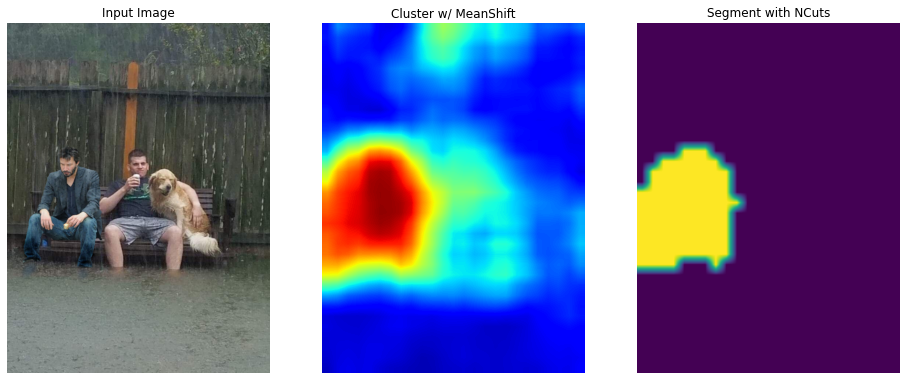

In [7]:
plt.subplots(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.imshow(img_cv)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Cluster w/ MeanShift')
plt.axis('off')
plt.imshow(out_ms, cmap='jet', vmin=0.0, vmax=1.0)

plt.subplot(1, 3, 3)
plt.title('Segment with NCuts')
plt.axis('off')
plt.imshow(out_ncuts, vmin=0.0, vmax=1.0)

plt.show()

# ANALYZE

In [6]:
model._init_img(img)

In [7]:
model.max_h_idx, model.max_w_idx

(31, 22)

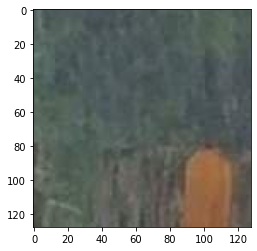

In [43]:
patch = model._get_patch(1, 9)
# patch = model.img
patch = patch.cpu().permute(1, 2, 0).numpy()

patch = (patch + 1) /2

# patch = patch.astype(int)
plt.imshow(patch)

In [39]:
patch_b = model._get_patch(16, 4)
# patch_b = model._get_patch(16, 4)
patches = next(model._patches_gen(682))

In [44]:
patch_b

tensor([[[-0.5608, -0.5216, -0.3176,  ..., -0.4275, -0.3647, -0.4118],
         [-0.5373, -0.5059, -0.3569,  ..., -0.4588, -0.4118, -0.4588],
         [-0.5137, -0.4745, -0.3647,  ..., -0.5059, -0.4824, -0.4745],
         ...,
         [ 0.2549,  0.3490,  0.3725,  ..., -0.4980, -0.5451, -0.4353],
         [ 0.1686,  0.3333,  0.3647,  ..., -0.5137, -0.6392, -0.5529],
         [ 0.0824,  0.2941,  0.3569,  ..., -0.5137, -0.6627, -0.6000]],

        [[-0.5294, -0.4431, -0.2078,  ..., -0.2863, -0.2235, -0.2706],
         [-0.5137, -0.4275, -0.2392,  ..., -0.3098, -0.2627, -0.3098],
         [-0.4745, -0.3882, -0.2471,  ..., -0.3333, -0.3098, -0.3255],
         ...,
         [-0.0824,  0.0118, -0.0039,  ..., -0.1765, -0.2235, -0.1137],
         [-0.1686,  0.0039,  0.0196,  ..., -0.2157, -0.3412, -0.2549],
         [-0.2471, -0.0118,  0.0275,  ..., -0.2314, -0.3804, -0.3020]],

        [[-0.6392, -0.5137, -0.1843,  ..., -0.1922, -0.1294, -0.1608],
         [-0.6000, -0.4902, -0.2157,  ..., -0

In [48]:
patch_b.min(), patch_b.max()

(tensor(-1., device='cuda:1'), tensor(1., device='cuda:1'))

In [46]:
patch_a.min(), patch_a.max()

(tensor(-0.4118, device='cuda:1'), tensor(0.3176, device='cuda:1'))

In [27]:
with torch.no_grad():
    pred = model.net.predict(patch_a, patch_b)
pred

tensor([0.9998], device='cuda:1')

In [40]:
preds = torch.zeros(682)

for i, patch_a in enumerate(patches):
    with torch.no_grad():
        preds[i] = model.net.predict(patch_a, patch_b)

In [41]:
preds.min(), preds.max()

(tensor(0.), tensor(0.))